## Imports & downloads


In [1]:
!wget https://www.dropbox.com/s/r6u59ljhhjdg6j0/negative.csv
!wget https://www.dropbox.com/s/fnpq3z4bcnoktiv/positive.csv 

--2021-11-25 18:03:49--  https://www.dropbox.com/s/r6u59ljhhjdg6j0/negative.csv
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.18, 2620:100:6018:18::a27d:312
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/r6u59ljhhjdg6j0/negative.csv [following]
--2021-11-25 18:03:49--  https://www.dropbox.com/s/raw/r6u59ljhhjdg6j0/negative.csv
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc4f7d649cdfee4042bb676bffdd.dl.dropboxusercontent.com/cd/0/inline/BapFHnwhV_bVf3t1Jo4GHRprYS7o3zlZzWGGZfuhcbs9MZuSQnVnr7xtrTrOzOWvgIktjGKovxffpP7CEy1dAOhJIA1oZopz7I3eLJFQPY5dwbDDJCW-aCa3c0Tgueh0ncruzFgN4uQjY2NEnuARo_rZ/file# [following]
--2021-11-25 18:03:49--  https://uc4f7d649cdfee4042bb676bffdd.dl.dropboxusercontent.com/cd/0/inline/BapFHnwhV_bVf3t1Jo4GHRprYS7o3zlZzWGGZfuhcbs9MZuSQnVnr7xtrTrOzOWvgIktjGKovxffpP7CEy1dAOhJIA

In [2]:
!pip install stanza torchmetrics gensim==3.8

     |████████████████████████████████| 432 kB 5.5 MB/s 
     |████████████████████████████████| 329 kB 41.7 MB/s 
     |████████████████████████████████| 24.2 MB 1.7 MB/s 
     |████████████████████████████████| 170 kB 49.3 MB/s 
  Created wheel for emoji: filename=emoji-1.6.1-py3-none-any.whl size=169314 sha256=331452ff78c909fb4c9512e0f552b99208963b3f6f3cabdccc035784a83d52ef
  Stored in directory: /root/.cache/pip/wheels/ea/5f/d3/03d313ddb3c2a1a427bb4690f1621eea60fe6f2a30cc95940f
Successfully built emoji
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0


In [3]:
import pandas as pd
from tqdm import tqdm
from collections import Counter
import string
import numpy as np

from sklearn.model_selection import train_test_split

import torch
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from torch.nn.utils.rnn import pad_sequence
import torch.nn as nn
import torch.optim as optim
from torchmetrics import F1
from torchmetrics.functional import f1, recall

from IPython.display import clear_output
import matplotlib.pyplot as plt

import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')

from gensim.models import KeyedVectors

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [4]:
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
DEVICE

device(type='cuda')

## Первая модель
Без устранения пунктуации

### Prepare Data

In [5]:
col_names = ['id', 'date', 'name', 'text', 'type', 'rep', 'ftw', 'fav', 'stcount', 'fol', 'frien', 'listcount']
neg_data = pd.read_csv('negative.csv', header=None, sep=';', names=col_names, index_col=0)
pos_data = pd.read_csv('positive.csv', header=None, sep=';', names=col_names, index_col=0)
data = pd.concat([neg_data, pos_data])
data.loc[data['type'] == -1, 'type'] = 0
data.head()

,date,name,text,type,rep,ftw,fav,stcount,fol,frien,listcount
id,,,,,,,,,,,
408906762813579264,1386325944,dugarchikbellko,на работе был полный пиддес :| и так каждое за...,0,0,0,0,8064,111,94,2
408906818262687744,1386325957,nugemycejela,"Коллеги сидят рубятся в Urban terror, а я из-з...",0,0,0,0,26,42,39,0
408906858515398656,1386325966,4post21,@elina_4post как говорят обещаного три года жд...,0,0,0,0,718,49,249,0
408906914437685248,1386325980,Poliwake,"Желаю хорошего полёта и удачной посадки,я буду...",0,0,0,0,10628,207,200,0
408906914723295232,1386325980,capyvixowe,"Обновил за каким-то лешим surf, теперь не рабо...",0,0,0,0,35,17,34,0


In [6]:
tokenized_texts = []
for i in tqdm(range(len(data))):
  tokenized_texts.append(word_tokenize(data['text'].iloc[i]))

100%|██████████| 226834/226834 [01:05<00:00, 3456.40it/s]


In [7]:
vocab = Counter()
for tokens in tokenized_texts:
    vocab.update(list(tokens))
print('Всего уникальных токенов:', len(vocab))

Всего уникальных токенов: 359652


In [8]:
filtered_vocab = set()
for token in vocab:
    if vocab[token] > 5:
        filtered_vocab.add(token)
print('Уникальных токенов, втретившихся больше 5 раз:', len(filtered_vocab))

Уникальных токенов, втретившихся больше 5 раз: 33670


In [9]:
word2id = {'PAD':0}

for token in filtered_vocab:
    word2id[token] = len(word2id)

In [10]:
id2word = {i:word for word, i in word2id.items()}

In [11]:
data['tokens'] = tokenized_texts
train_data, val_data = train_test_split(data, test_size=0.2)
print(f'Train size:      {len(train_data)}')
print(f'Validation size: {len(val_data)}')

Train size:      181467
Validation size: 45367


### Create Dataset

In [12]:
class TweetDataset(Dataset):

    def __init__(self, dataset, word2id, DEVICE):
        self.dataset = dataset['tokens'].values
        self.word2id = word2id
        self.length = dataset.shape[0]
        self.target = dataset['type'].values
        self.device = DEVICE

    def __len__(self):
        return self.length

    def __getitem__(self, index): 
        words = list(self.dataset[index])
        ids = torch.LongTensor([self.word2id[word] for word in words if word in self.word2id])
        y = [self.target[index]]
        return ids, y

    def collate_fn(self, batch): 
      ids, y = list(zip(*batch))
      padded_ids = pad_sequence(ids, batch_first=True).to(self.device)
      y = torch.Tensor(y).to(self.device)
      return padded_ids, y

In [13]:
train_dataset = TweetDataset(train_data, word2id, DEVICE)
train_sampler = RandomSampler(train_dataset)
train_iterator = DataLoader(train_dataset, collate_fn = train_dataset.collate_fn, sampler=train_sampler, batch_size=1024)

In [14]:
val_dataset = TweetDataset(val_data, word2id, DEVICE)
val_sampler = SequentialSampler(val_dataset)
val_iterator = DataLoader(val_dataset, collate_fn = val_dataset.collate_fn, sampler=val_sampler, batch_size=1024)

### Model class


In [15]:
class CNN(nn.Module):
    
    def __init__(self, vocab_size, embedding_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.bigrams = nn.Conv1d(in_channels=embedding_dim, out_channels=100, kernel_size=2, padding='same')
        self.trigrams = nn.Conv1d(in_channels=embedding_dim, out_channels=100, kernel_size=3, padding='same')
        self.final_cnn = nn.Conv1d(in_channels=200, out_channels=80, kernel_size=3, padding='same')
        self.hidden = nn.Linear(in_features=80, out_features=1)
        self.out = nn.Sigmoid()

    def forward(self, word):
        # эмбеддинг слой
        embedded = self.embedding(word)
        embedded = embedded.transpose(1,2)
        
        # CNN c фильтрами с разным окном
        bigrams = self.bigrams(embedded)
        trigrams = self.trigrams(embedded)
        # еще один сверточный слой
        final = self.final_cnn(torch.cat((bigrams, trigrams), 1))

        # max pooling over time
        pooling = final.max(2)[0] 
        # линейный слой + сигмоида
        logits = self.hidden(pooling) 
        logits = self.out(logits)      
        return logits

In [16]:
def train(model, iterator, optimizer, criterion):
    epoch_loss = 0
    
    model.train()

    for i, (texts, ys) in enumerate(iterator):
        optimizer.zero_grad()
        preds = model(texts)
        loss = criterion(preds, ys)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    return  epoch_loss / len(iterator)

In [17]:
def evaluate(model, iterator, criterion):
    epoch_loss = 0
    epoch_metric = 0
    model.eval() 
    with torch.no_grad():
        for i, (texts, ys) in enumerate(iterator):   
            preds = model(texts)
            loss = criterion(preds, ys)
            epoch_loss += loss.item()
            batch_metric = f1(preds.round().long(), ys.long(), ignore_index=0)
            epoch_metric += batch_metric
    return epoch_metric / len(iterator), epoch_loss / len(iterator)

In [38]:
model = CNN(len(word2id), 8)
optimizer = optim.Adam(model.parameters(), lr=0.0005)
criterion = nn.BCELoss()  

In [39]:
model = model.to(DEVICE)
criterion = criterion.to(DEVICE)

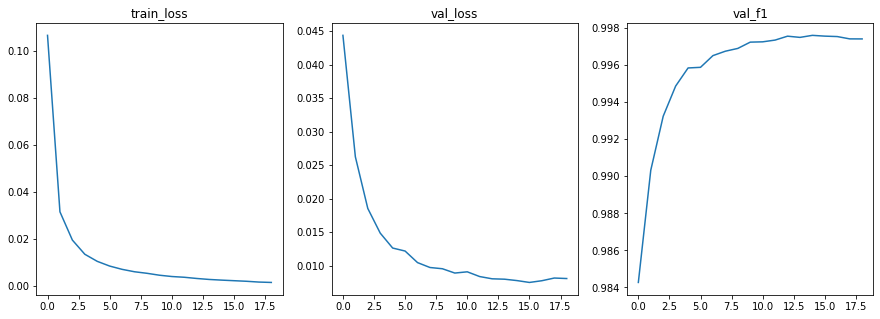

  Train loss:      0.001550
  Validation Loss: 0.008072
  Validation F1:   0.997425

Epoch 19


In [40]:
losses = []
losses_eval = []
f1s = []
f1s_eval = []
log = {'train_loss': [], 'val_loss': [], 'val_f1': []}

for i in range(20):
    print(f'\nEpoch {i}')
    epoch_loss = train(model, train_iterator, optimizer, criterion)
    losses.append(epoch_loss)
    f1_on_train,_ = evaluate(model, train_iterator, criterion)
    f1s.append(f1_on_train)
    f1_on_test, epoch_loss_on_test = evaluate(model, val_iterator, criterion)
    losses_eval.append(epoch_loss_on_test)
    f1s_eval.append(f1_on_test)
    log['train_loss'] = losses
    log['val_loss'] = losses_eval
    log['val_f1'] = f1s_eval

    if i % 3 == 0:
        clear_output(wait=True)
        fig, axs = plt.subplots(1, len(log), figsize=(15, 5))
        for i, (name, vals) in enumerate(log.items()):
            axs[i].plot(vals)
            axs[i].set_title(name)
        plt.show()
        print("  Train loss:      {0:.6f}".format(epoch_loss))
        print("  Validation Loss: {0:.6f}".format(epoch_loss_on_test))
        print("  Validation F1:   {0:.6f}".format(f1_on_test))

Лосс сразу очень маленький, а F1-метрика очень близка к 1. Кажется, в договорились сначала убрать пунктуацию, чтобы модель не видела смайлики и показывала результаты хуже. Попробуем!

## Первая модель 
Уберем пунктуацию (испортим качество), чтобы было куда улучшать

### Prepare data

In [33]:
tokenized_texts = []
for i in tqdm(range(len(data))):
  tokens = word_tokenize(data['text'].iloc[i])
  tokens = [token for token in tokens if token not in string.punctuation]
  tokenized_texts.append(tokens)

100%|██████████| 226834/226834 [01:05<00:00, 3444.66it/s]


In [34]:
vocab = Counter()
for tokens in tokenized_texts:
    vocab.update(list(tokens))

filtered_vocab = set()
for token in vocab:
    if vocab[token] > 5:
        filtered_vocab.add(token)

In [35]:
word2id = {'PAD':0}

for token in filtered_vocab:
    word2id[token] = len(word2id)

id2word = {i:word for word, i in word2id.items()}

In [36]:
data['tokens'] = tokenized_texts
train_data, val_data = train_test_split(data, test_size=0.2)

### Create Dataset

In [ ]:
train_dataset = TweetDataset(train_data, word2id, DEVICE)
train_sampler = RandomSampler(train_dataset)
train_iterator = DataLoader(train_dataset, collate_fn = train_dataset.collate_fn, sampler=train_sampler, batch_size=1024)

In [ ]:
val_dataset = TweetDataset(val_data, word2id, DEVICE)
val_sampler = SequentialSampler(val_dataset)
val_iterator = DataLoader(val_dataset, collate_fn = val_dataset.collate_fn, sampler=val_sampler, batch_size=1024)

### Train

In [ ]:
torch.manual_seed(100)
np.random.seed(100)

model = CNN(len(word2id), 8)
optimizer = optim.Adam(model.parameters(), lr=0.0005)
criterion = nn.BCELoss()  

In [ ]:
model = model.to(DEVICE)
criterion = criterion.to(DEVICE)

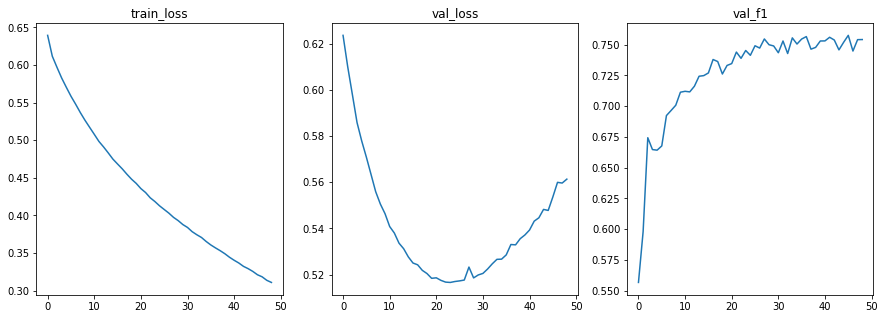

  Train loss:      0.310847
  Validation Loss: 0.561347
  Validation F1:   0.754148

Epoch 49


In [ ]:
losses = []
losses_eval = []
f1s = []
f1s_eval = []
log = {'train_loss': [], 'val_loss': [], 'val_f1': []}

for i in range(50):
    print(f'\nEpoch {i}')
    epoch_loss = train(model, train_iterator, optimizer, criterion)
    losses.append(epoch_loss)
    f1_on_train,_ = evaluate(model, train_iterator, criterion)
    f1s.append(f1_on_train)
    f1_on_test, epoch_loss_on_test = evaluate(model, val_iterator, criterion)
    losses_eval.append(epoch_loss_on_test)
    f1s_eval.append(f1_on_test)
    log['train_loss'] = losses
    log['val_loss'] = losses_eval
    log['val_f1'] = f1s_eval

    if i % 3 == 0:
        clear_output(wait=True)
        fig, axs = plt.subplots(1, len(log), figsize=(15, 5))
        for i, (name, vals) in enumerate(log.items()):
            axs[i].plot(vals)
            axs[i].set_title(name)
        plt.show()
        print("  Train loss:      {0:.6f}".format(epoch_loss))
        print("  Validation Loss: {0:.6f}".format(epoch_loss_on_test))
        print("  Validation F1:   {0:.6f}".format(f1_on_test))

In [ ]:
print(f'Best F1 on validation: {max(f1s_eval):.4f}')
print(f'Best epoch: {np.argmax(f1s_eval)}')

Best F1 on validation: 0.7576
Best epoch: 45


После 30 эпохи лосс начал расти, а F1 перестала значительно увеличиваться. Возможно, далее 40 эпох будет достаточно. 

## Добавление готовых эмбеддингов

##### More imports & downloads

In [18]:
!wget https://rusvectores.org/static/models/rusvectores4/fasttext/araneum_none_fasttextcbow_300_5_2018.tgz

--2021-11-25 18:07:00--  https://rusvectores.org/static/models/rusvectores4/fasttext/araneum_none_fasttextcbow_300_5_2018.tgz
Resolving rusvectores.org (rusvectores.org)... 116.203.104.23
Connecting to rusvectores.org (rusvectores.org)|116.203.104.23|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2691248108 (2.5G) [application/x-gzip]
Saving to: ‘araneum_none_fasttextcbow_300_5_2018.tgz’

araneum_none_fastte 100%[===================>]   2.51G  24.7MB/s    in 1m 45s  

2021-11-25 18:08:46 (24.4 MB/s) - ‘araneum_none_fasttextcbow_300_5_2018.tgz’ saved [2691248108/2691248108]



In [19]:
!tar -xvzf /content/araneum_none_fasttextcbow_300_5_2018.tgz

araneum_none_fasttextcbow_300_5_2018.model
araneum_none_fasttextcbow_300_5_2018.model.vectors_ngrams.npy
araneum_none_fasttextcbow_300_5_2018.model.vectors.npy
araneum_none_fasttextcbow_300_5_2018.model.vectors_vocab.npy


##### Embedding models and model class


In [20]:
model_emb = KeyedVectors.load('araneum_none_fasttextcbow_300_5_2018.model')

In [27]:
weights = np.zeros((len(word2id), 300))
count = 0
for word, i in word2id.items():
    if word == 'PAD':
        continue   
    weights[i] = model_emb[word]    

In [ ]:
class CNN(nn.Module):
    
    def __init__(self, vocab_size, weights):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, weights.shape[1])
        self.embedding.from_pretrained(torch.tensor(weights), freeze=True)
        self.bigrams = nn.Conv1d(in_channels=weights.shape[1], out_channels=100, kernel_size=2, padding='same')
        self.trigrams = nn.Conv1d(in_channels=weights.shape[1], out_channels=100, kernel_size=3, padding='same')
        self.final_cnn = nn.Conv1d(in_channels=200, out_channels=80, kernel_size=3, padding='same')
        self.hidden = nn.Linear(in_features=80, out_features=1)
        self.out = nn.Sigmoid()

    def forward(self, word):
        embedded = self.embedding(word)
        embedded = embedded.transpose(1,2)

        bigrams = self.bigrams(embedded)
        trigrams = self.trigrams(embedded)
        final = self.final_cnn(torch.cat((bigrams, trigrams), 1))

        pooling = final.max(2)[0] 
        logits = self.hidden(pooling) 
        logits = self.out(logits)      
        return logits

In [ ]:
torch.manual_seed(100)
np.random.seed(100)

model = CNN(len(word2id), weights)
optimizer = optim.Adam(model.parameters(), lr=0.0005)
criterion = nn.BCELoss()  

model = model.to(DEVICE)
criterion = criterion.to(DEVICE)

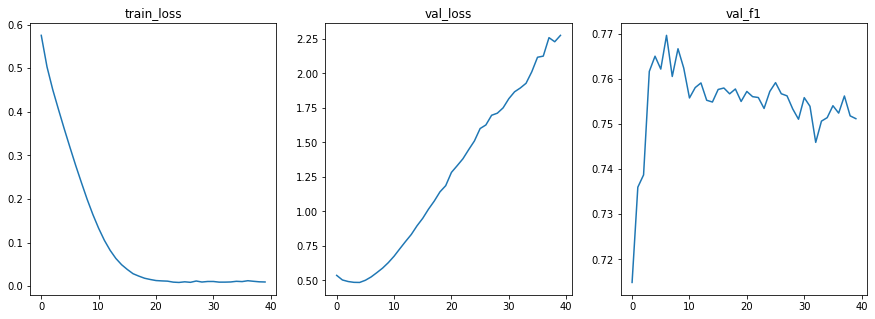

  Train loss:      0.009487
  Validation Loss: 2.275831
  Validation F1:   0.751172


In [ ]:
losses = []
losses_eval = []
f1s = []
f1s_eval = []
log = {'train_loss': [], 'val_loss': [], 'val_f1': []}

for i in range(40):
    print(f'\nEpoch {i}')
    epoch_loss = train(model, train_iterator, optimizer, criterion)
    losses.append(epoch_loss)
    f1_on_train,_ = evaluate(model, train_iterator, criterion)
    f1s.append(f1_on_train)
    f1_on_test, epoch_loss_on_test = evaluate(model, val_iterator, criterion)
    losses_eval.append(epoch_loss_on_test)
    f1s_eval.append(f1_on_test)
    log['train_loss'] = losses
    log['val_loss'] = losses_eval
    log['val_f1'] = f1s_eval

    if i % 3 == 0:
        clear_output(wait=True)
        fig, axs = plt.subplots(1, len(log), figsize=(15, 5))
        for i, (name, vals) in enumerate(log.items()):
            axs[i].plot(vals)
            axs[i].set_title(name)
        plt.show()
        print("  Train loss:      {0:.6f}".format(epoch_loss))
        print("  Validation Loss: {0:.6f}".format(epoch_loss_on_test))
        print("  Validation F1:   {0:.6f}".format(f1_on_test))

In [ ]:
print(f'Best F1 on validation: {max(f1s_eval):.4f}')
print(f'Best epoch: {np.argmax(f1s_eval)}')

Best F1 on validation: 0.7696
Best epoch: 6


## Улучшение первой модели

Для дальнейших экспериментов возьму модель с обученными эмбеддингами, потому что она обучается намного быстрее и результаты оказались немного получше.  
Для начала добавим Dropout и ReLU в модель.

In [ ]:
class CNN(nn.Module):
    
    def __init__(self, vocab_size, weights):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, weights.shape[1])
        self.embedding.from_pretrained(torch.tensor(weights), freeze=True)
        self.bigrams = nn.Conv1d(in_channels=weights.shape[1], out_channels=100, kernel_size=2, padding='same')
        self.trigrams = nn.Conv1d(in_channels=weights.shape[1], out_channels=100, kernel_size=3, padding='same')
        self.final_cnn = nn.Conv1d(in_channels=200, out_channels=80, kernel_size=3, padding='same')
        self.hidden = nn.Linear(in_features=80, out_features=1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.5)
        self.out = nn.Sigmoid()

    def forward(self, word):
        embedded = self.embedding(word)
        embedded = embedded.transpose(1,2)

        bigrams = self.bigrams(embedded)
        trigrams = self.trigrams(embedded)
        final = self.final_cnn(torch.cat((bigrams, trigrams), 1))
        filal = self.dropout(self.relu(final))

        pooling = final.max(2)[0] 
        logits = self.hidden(pooling) 
        logits = self.out(logits)      
        return logits

In [ ]:
torch.manual_seed(100)
np.random.seed(100)

model = CNN(len(word2id), weights)
optimizer = optim.Adam(model.parameters(), lr=0.0005)
criterion = nn.BCELoss()  

model = model.to(DEVICE)
criterion = criterion.to(DEVICE)

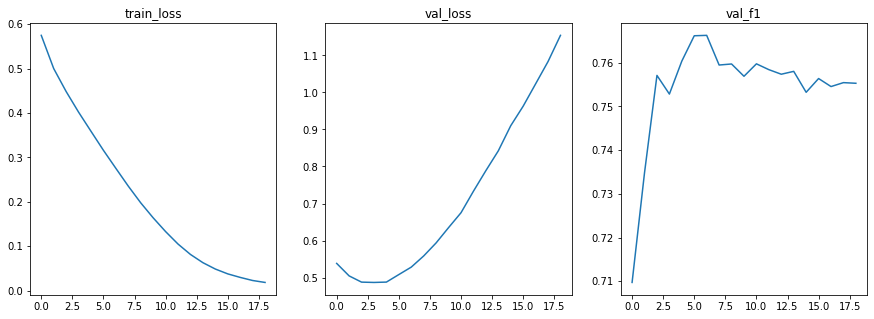

  Train loss:      0.018167
  Validation Loss: 1.153983
  Validation F1:   0.755280

Epoch 19


In [ ]:
losses = []
losses_eval = []
f1s = []
f1s_eval = []
log = {'train_loss': [], 'val_loss': [], 'val_f1': []}

for i in range(20):
    print(f'\nEpoch {i}')
    epoch_loss = train(model, train_iterator, optimizer, criterion)
    losses.append(epoch_loss)
    f1_on_train,_ = evaluate(model, train_iterator, criterion)
    f1s.append(f1_on_train)
    f1_on_test, epoch_loss_on_test = evaluate(model, val_iterator, criterion)
    losses_eval.append(epoch_loss_on_test)
    f1s_eval.append(f1_on_test)
    log['train_loss'] = losses
    log['val_loss'] = losses_eval
    log['val_f1'] = f1s_eval

    if i % 3 == 0:
        clear_output(wait=True)
        fig, axs = plt.subplots(1, len(log), figsize=(15, 5))
        for i, (name, vals) in enumerate(log.items()):
            axs[i].plot(vals)
            axs[i].set_title(name)
        plt.show()
        print("  Train loss:      {0:.6f}".format(epoch_loss))
        print("  Validation Loss: {0:.6f}".format(epoch_loss_on_test))
        print("  Validation F1:   {0:.6f}".format(f1_on_test))

In [ ]:
print(f'Best F1 on validation: {max(f1s_eval):.4f}')
print(f'Best epoch: {np.argmax(f1s_eval)}')

Best F1 on validation: 0.7662
Best epoch: 6


Общее качество не повысилось, но качество начало падать не так резко после 5 эпохи, как в предыдущей модели (см графики)

Уменьшу learning rate и добавлю ReLU, Dropout ко всем сверточным слоям, а не только к последнему.

In [ ]:
class CNN(nn.Module):
    
    def __init__(self, vocab_size, weights):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, weights.shape[1])
        self.embedding.from_pretrained(torch.tensor(weights), freeze=True)
        self.bigrams = nn.Conv1d(in_channels=weights.shape[1], out_channels=100, kernel_size=2, padding='same')
        self.trigrams = nn.Conv1d(in_channels=weights.shape[1], out_channels=100, kernel_size=3, padding='same')
        self.final_cnn = nn.Conv1d(in_channels=200, out_channels=80, kernel_size=3, padding='same')
        self.hidden = nn.Linear(in_features=80, out_features=1)
        # активации
        self.relu2 = nn.ReLU()
        self.relu3 = nn.ReLU()
        self.relu_final = nn.ReLU()
        # дропауты
        self.dropout2 = nn.Dropout(p=0.3)
        self.dropout3 = nn.Dropout(p=0.3)
        self.dropout_final = nn.Dropout(p=0.3)
        self.out = nn.Sigmoid()

    def forward(self, word):
        embedded = self.embedding(word)
        embedded = embedded.transpose(1,2)

        bigrams = self.dropout2(self.relu2(self.bigrams(embedded)))
        trigrams = self.dropout3(self.relu3(self.trigrams(embedded)))
        final = self.final_cnn(torch.cat((bigrams, trigrams), 1))
        filal = self.dropout_final(self.relu_final(final))

        pooling = final.max(2)[0] 
        logits = self.hidden(pooling) 
        logits = self.out(logits)      
        return logits

In [ ]:
torch.manual_seed(100)
np.random.seed(100)

model = CNN(len(word2id), weights)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.BCELoss()  

model = model.to(DEVICE)
criterion = criterion.to(DEVICE)

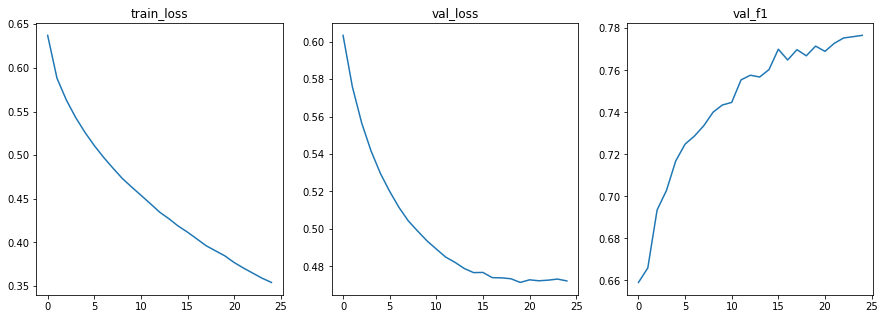

  Train loss:      0.354092
  Validation Loss: 0.472214
  Validation F1:   0.776641


In [ ]:
losses = []
losses_eval = []
f1s = []
f1s_eval = []
log = {'train_loss': [], 'val_loss': [], 'val_f1': []}

for i in range(25):
    print(f'\nEpoch {i}')
    epoch_loss = train(model, train_iterator, optimizer, criterion)
    losses.append(epoch_loss)
    f1_on_train,_ = evaluate(model, train_iterator, criterion)
    f1s.append(f1_on_train)
    f1_on_test, epoch_loss_on_test = evaluate(model, val_iterator, criterion)
    losses_eval.append(epoch_loss_on_test)
    f1s_eval.append(f1_on_test)
    log['train_loss'] = losses
    log['val_loss'] = losses_eval
    log['val_f1'] = f1s_eval

    if i % 3 == 0:
        clear_output(wait=True)
        fig, axs = plt.subplots(1, len(log), figsize=(15, 5))
        for i, (name, vals) in enumerate(log.items()):
            axs[i].plot(vals)
            axs[i].set_title(name)
        plt.show()
        print("  Train loss:      {0:.6f}".format(epoch_loss))
        print("  Validation Loss: {0:.6f}".format(epoch_loss_on_test))
        print("  Validation F1:   {0:.6f}".format(f1_on_test))

In [ ]:
print(f'Best F1 on validation: {max(f1s_eval):.4f}')
print(f'Best epoch: {np.argmax(f1s_eval)}')

Best F1 on validation: 0.7766
Best epoch: 24


Возможно, модель училась бы еще дальше, но качество уже улучшилось, а впереди еще много экспериментов, так что остановимся тут.

Еще попробуем добавить нормализацию батчей

In [ ]:
class CNN(nn.Module):
    
    def __init__(self, vocab_size, weights):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, weights.shape[1])
        self.embedding.from_pretrained(torch.tensor(weights), freeze=True)
        self.bigrams = nn.Conv1d(in_channels=weights.shape[1], out_channels=100, kernel_size=2, padding='same')
        self.trigrams = nn.Conv1d(in_channels=weights.shape[1], out_channels=100, kernel_size=3, padding='same')
        self.final_cnn = nn.Conv1d(in_channels=200, out_channels=80, kernel_size=3, padding='same')
        self.hidden = nn.Linear(in_features=80, out_features=1)
        self.bnorm2 = nn.BatchNorm1d(100)
        self.bnorm3 = nn.BatchNorm1d(100)
        self.bnorm_final = nn.BatchNorm1d(80)
        self.relu2 = nn.ReLU()
        self.relu3 = nn.ReLU()
        self.relu_final = nn.ReLU()
        self.dropout2 = nn.Dropout(p=0.3)
        self.dropout3 = nn.Dropout(p=0.3)
        self.dropout_final = nn.Dropout(p=0.3)
        self.out = nn.Sigmoid()

    def forward(self, word):
        embedded = self.embedding(word)
        embedded = embedded.transpose(1,2)

        bigrams = self.dropout2(self.relu2(self.bnorm2(self.bigrams(embedded))))
        trigrams = self.dropout3(self.relu3(self.bnorm3(self.trigrams(embedded))))
        final = self.final_cnn(torch.cat((bigrams, trigrams), 1))
        filal = self.dropout_final(self.relu_final(self.bnorm_final(final)))

        pooling = final.max(2)[0] 
        logits = self.hidden(pooling) 
        logits = self.out(logits)      
        return logits

In [ ]:
torch.manual_seed(100)
np.random.seed(100)

model = CNN(len(word2id), weights)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.BCELoss()  

model = model.to(DEVICE)
criterion = criterion.to(DEVICE)

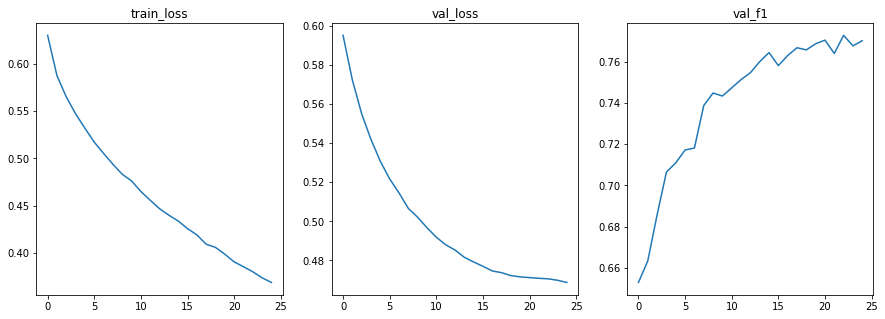

  Train loss:      0.369157
  Validation Loss: 0.468750
  Validation F1:   0.770195


In [ ]:
losses = []
losses_eval = []
f1s = []
f1s_eval = []
log = {'train_loss': [], 'val_loss': [], 'val_f1': []}

for i in range(25):
    print(f'\nEpoch {i}')
    epoch_loss = train(model, train_iterator, optimizer, criterion)
    losses.append(epoch_loss)
    f1_on_train,_ = evaluate(model, train_iterator, criterion)
    f1s.append(f1_on_train)
    f1_on_test, epoch_loss_on_test = evaluate(model, val_iterator, criterion)
    losses_eval.append(epoch_loss_on_test)
    f1s_eval.append(f1_on_test)
    log['train_loss'] = losses
    log['val_loss'] = losses_eval
    log['val_f1'] = f1s_eval

    if i % 3 == 0:
        clear_output(wait=True)
        fig, axs = plt.subplots(1, len(log), figsize=(15, 5))
        for i, (name, vals) in enumerate(log.items()):
            axs[i].plot(vals)
            axs[i].set_title(name)
        plt.show()
        print("  Train loss:      {0:.6f}".format(epoch_loss))
        print("  Validation Loss: {0:.6f}".format(epoch_loss_on_test))
        print("  Validation F1:   {0:.6f}".format(f1_on_test))

In [ ]:
print(f'Best F1 on validation: {max(f1s_eval):.4f}')
print(f'Best epoch: {np.argmax(f1s_eval)}')

Best F1 on validation: 0.7728
Best epoch: 22


Прошлая модель показала результаты лучше, но эта все равно превосходит бейзлайн.

## Вторая модель

#### Create Dataset

In [21]:
vocab = Counter()
for symbol in data['text']:
    vocab.update(list(symbol))
print('Всего уникальных символов:', len(vocab))

filtered_vocab = set()

for symbol in vocab:
    if vocab[symbol] > 5:
        filtered_vocab.add(symbol)
print('Уникальных символов, втретившихся больше 5 раз:', len(filtered_vocab))

Всего уникальных символов: 456
Уникальных символов, втретившихся больше 5 раз: 234


In [22]:
symbol2id = {'PAD':0}

for symbol in filtered_vocab:
    symbol2id[symbol] = len(symbol2id)

id2symbol = {i:symbol for symbol, i in symbol2id.items()}

In [43]:
class TweetDataset(Dataset):

    def __init__(self, dataset, word2id, symbol2id, DEVICE):
        self.dataset_tokens = dataset['tokens'].values
        self.dataset_texts = dataset['text'].values
        self.word2id = word2id
        self.symbol2id = symbol2id
        self.length = dataset.shape[0]
        self.target = dataset['type'].values
        self.device = DEVICE

    def __len__(self):
        return self.length

    def __getitem__(self, index): 
        words = list(self.dataset_tokens[index])
        word_ids = torch.LongTensor([self.word2id[word] for word in words if word in self.word2id])
        symbols = list(self.dataset_texts[index])
        sym_ids = torch.LongTensor([self.symbol2id[symbol] for symbol in symbols if symbol in self.symbol2id])
        y = [self.target[index]]
        return word_ids, sym_ids, y

    def collate_fn(self, batch): 
      word_ids, sym_ids, y = list(zip(*batch))
      padded_word_ids = pad_sequence(word_ids, batch_first=True).to(self.device)
      padded_sym_ids = pad_sequence(sym_ids, batch_first=True).to(self.device)
      y = torch.Tensor(y).to(self.device)
      return padded_word_ids, padded_sym_ids, y

In [44]:
train_dataset = TweetDataset(train_data, word2id, symbol2id, DEVICE)
train_sampler = RandomSampler(train_dataset)
train_iterator = DataLoader(train_dataset, collate_fn = train_dataset.collate_fn, sampler=train_sampler, batch_size=1024)

val_dataset = TweetDataset(val_data, word2id, symbol2id, DEVICE)
val_sampler = SequentialSampler(val_dataset)
val_iterator = DataLoader(val_dataset, collate_fn = val_dataset.collate_fn, sampler=val_sampler, batch_size=1024)

#### Model class

In [49]:
def train(model, iterator, optimizer, criterion):
    epoch_loss = 0
    
    model.train()

    for i, (words, symbols, ys) in enumerate(iterator):
        optimizer.zero_grad()
        preds = model(words, symbols)
        loss = criterion(preds, ys)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    return  epoch_loss / len(iterator)

In [50]:
def evaluate(model, iterator, criterion):
    epoch_loss = 0
    epoch_metric = 0
    model.eval() 
    with torch.no_grad():
        for i, (words, symbols, ys) in enumerate(iterator):   
            preds = model(words, symbols)
            loss = criterion(preds, ys)
            epoch_loss += loss.item()
            batch_metric = f1(preds.round().long(), ys.long(), ignore_index=0)
            epoch_metric += batch_metric
    return epoch_metric / len(iterator), epoch_loss / len(iterator)

In [47]:
class CNN(nn.Module):
    
    def __init__(self, word_vocab_size, sym_vocab_size, embedding_dim, weights):
        super().__init__()
        self.word_embedding = nn.Embedding(word_vocab_size, weights.shape[1])
        self.word_embedding.from_pretrained(torch.tensor(weights), freeze=True)
        self.word_hidden = nn.Linear(in_features=weights.shape[1], out_features=80)

        self.sym_embedding = nn.Embedding(sym_vocab_size, embedding_dim)
        self.bigrams = nn.Conv1d(in_channels=embedding_dim, out_channels=100, kernel_size=2, padding='same')
        self.trigrams = nn.Conv1d(in_channels=embedding_dim, out_channels=100, kernel_size=3, padding='same')
        self.final_cnn = nn.Conv1d(in_channels=200, out_channels=80, kernel_size=3, padding='same')
        
        self.hidden = nn.Linear(in_features=80+80, out_features=1)
        self.out = nn.Sigmoid()

    def forward(self, word, symbols):
        # предобученные эмбеддинги для слов
        word_embedded = self.word_embedding(word)
        # усредненные эмбеддинги - эмбеддинг предложения
        mean_word_emb = torch.mean(word_embedded, dim=1)
        # линейный слой поверх вектора предложения
        word_hidden = self.word_hidden(mean_word_emb)

        # обучаемые эмбеддинги символов
        sym_embedded = self.sym_embedding(symbols)
        sym_embedded = sym_embedded.transpose(1,2)

        # сверточные слои с разным окном
        bigrams = self.bigrams(sym_embedded)
        trigrams = self.trigrams(sym_embedded)
        final = self.final_cnn(torch.cat((bigrams, trigrams), 1))
        
        # max pooling over time
        pooling = final.max(2)[0] 
        # линейный слой + сигмоида
        logits = self.hidden(torch.cat((pooling, word_hidden), 1))
        logits = self.out(logits)      
        return logits

#### Training

In [ ]:
torch.manual_seed(100)
np.random.seed(100)

model = CNN(len(word2id), len(symbol2id), 8, weights)
optimizer = optim.Adam(model.parameters(), lr=0.0005)
criterion = nn.BCELoss()  

model = model.to(DEVICE)
criterion = criterion.to(DEVICE)

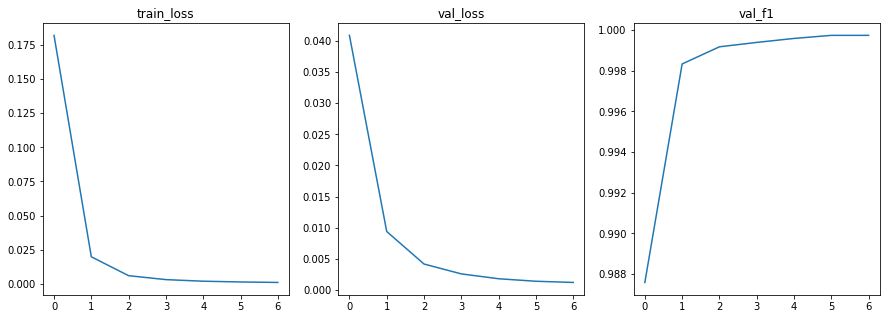

  Train loss:      0.000963
  Validation Loss: 0.001187
  Validation F1:   0.999740


In [ ]:
losses = []
losses_eval = []
f1s = []
f1s_eval = []
log = {'train_loss': [], 'val_loss': [], 'val_f1': []}

for i in range(7):
    print(f'\nEpoch {i}')
    epoch_loss = train(model, train_iterator, optimizer, criterion)
    losses.append(epoch_loss)
    f1_on_train,_ = evaluate(model, train_iterator, criterion)
    f1s.append(f1_on_train)
    f1_on_test, epoch_loss_on_test = evaluate(model, val_iterator, criterion)
    losses_eval.append(epoch_loss_on_test)
    f1s_eval.append(f1_on_test)
    log['train_loss'] = losses
    log['val_loss'] = losses_eval
    log['val_f1'] = f1s_eval

    if i % 3 == 0:
        clear_output(wait=True)
        fig, axs = plt.subplots(1, len(log), figsize=(15, 5))
        for i, (name, vals) in enumerate(log.items()):
            axs[i].plot(vals)
            axs[i].set_title(name)
        plt.show()
        print("  Train loss:      {0:.6f}".format(epoch_loss))
        print("  Validation Loss: {0:.6f}".format(epoch_loss_on_test))
        print("  Validation F1:   {0:.6f}".format(f1_on_test))

Буквально сразу же F1 почти 1. Проблема известная - если модель видит смайлики, то справляется отлично, а в создании символов я пунктуацию сейчас сохраняла.  
Ниже уберу пунктуацию и обучу снова.

## Вторая модель без пунктуации в символах

#### Dataset

In [44]:
class TweetDataset(Dataset):

    def __init__(self, dataset, word2id, symbol2id, DEVICE):
        self.dataset_tokens = dataset['tokens'].values
        # теперь берем символы не по тексту, а по склеенным токенам без пунктуации
        self.dataset_texts = dataset['tokens'].str.join(' ').values
        self.word2id = word2id
        self.symbol2id = symbol2id
        self.length = dataset.shape[0]
        self.target = dataset['type'].values
        self.device = DEVICE

    def __len__(self):
        return self.length

    def __getitem__(self, index): 
        words = list(self.dataset_tokens[index])
        word_ids = torch.LongTensor([self.word2id[word] for word in words if word in self.word2id])
        symbols = list(self.dataset_texts[index])
        sym_ids = torch.LongTensor([self.symbol2id[symbol] for symbol in symbols if symbol in self.symbol2id])
        y = [self.target[index]]
        return word_ids, sym_ids, y

    def collate_fn(self, batch): 
      word_ids, sym_ids, y = list(zip(*batch))
      padded_word_ids = pad_sequence(word_ids, batch_first=True).to(self.device)
      padded_sym_ids = pad_sequence(sym_ids, batch_first=True).to(self.device)
      y = torch.Tensor(y).to(self.device)
      return padded_word_ids, padded_sym_ids, y

In [45]:
train_dataset = TweetDataset(train_data, word2id, symbol2id, DEVICE)
train_sampler = RandomSampler(train_dataset)
train_iterator = DataLoader(train_dataset, collate_fn = train_dataset.collate_fn, sampler=train_sampler, batch_size=1024)

val_dataset = TweetDataset(val_data, word2id, symbol2id, DEVICE)
val_sampler = SequentialSampler(val_dataset)
val_iterator = DataLoader(val_dataset, collate_fn = val_dataset.collate_fn, sampler=val_sampler, batch_size=1024)

#### Training

In [ ]:
torch.manual_seed(100)
np.random.seed(100)

model = CNN(len(word2id), len(symbol2id), 8, weights)
optimizer = optim.Adam(model.parameters(), lr=0.0005)
criterion = nn.BCELoss()  

model = model.to(DEVICE)
criterion = criterion.to(DEVICE)

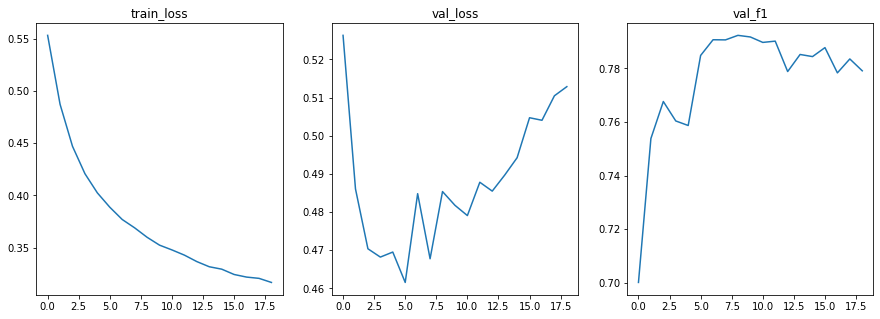

  Train loss:      0.316655
  Validation Loss: 0.512877
  Validation F1:   0.779131

Epoch 19


In [ ]:
losses = []
losses_eval = []
f1s = []
f1s_eval = []
log = {'train_loss': [], 'val_loss': [], 'val_f1': []}

for i in range(20):
    print(f'\nEpoch {i}')
    epoch_loss = train(model, train_iterator, optimizer, criterion)
    losses.append(epoch_loss)
    f1_on_train,_ = evaluate(model, train_iterator, criterion)
    f1s.append(f1_on_train)
    f1_on_test, epoch_loss_on_test = evaluate(model, val_iterator, criterion)
    losses_eval.append(epoch_loss_on_test)
    f1s_eval.append(f1_on_test)
    log['train_loss'] = losses
    log['val_loss'] = losses_eval
    log['val_f1'] = f1s_eval

    if i % 3 == 0:
        clear_output(wait=True)
        fig, axs = plt.subplots(1, len(log), figsize=(15, 5))
        for i, (name, vals) in enumerate(log.items()):
            axs[i].plot(vals)
            axs[i].set_title(name)
        plt.show()
        print("  Train loss:      {0:.6f}".format(epoch_loss))
        print("  Validation Loss: {0:.6f}".format(epoch_loss_on_test))
        print("  Validation F1:   {0:.6f}".format(f1_on_test))

In [ ]:
print(f'Best F1 on validation: {max(f1s_eval):.4f}')
print(f'Best epoch: {np.argmax(f1s_eval)}')

Best F1 on validation: 0.7924
Best epoch: 8


Модель с информацией о символах справляется с предсказанием негативности/позитивности лучше, чем только на словах!  
Наверное, готовые пословные эмбеддинги для псевдослов и неотсеянной пунктуации несколько хуже, чем обучаемые символьные эмбеддинги.

## Улучшение второй модели (без пунктуации)  

Добавляю еще один линейный слой в конце. Перед ним выход из предыдущего линейного слоя сначала проходит активацию.

In [57]:
class CNN(nn.Module):
    
    def __init__(self, word_vocab_size, sym_vocab_size, embedding_dim, weights):
        super().__init__()
        self.word_embedding = nn.Embedding(word_vocab_size, weights.shape[1])
        self.word_embedding.from_pretrained(torch.tensor(weights), freeze=True)
        self.word_hidden = nn.Linear(in_features=weights.shape[1], out_features=80)

        self.sym_embedding = nn.Embedding(sym_vocab_size, embedding_dim)
        self.bigrams = nn.Conv1d(in_channels=embedding_dim, out_channels=100, kernel_size=2, padding='same')
        self.trigrams = nn.Conv1d(in_channels=embedding_dim, out_channels=100, kernel_size=3, padding='same')
        self.final_cnn = nn.Conv1d(in_channels=200, out_channels=80, kernel_size=3, padding='same')
        
        self.hidden1 = nn.Linear(in_features=80+80, out_features=80)
        self.hidden2 = nn.Linear(in_features=80, out_features=1)
        self.act = nn.ReLU()
        self.out = nn.Sigmoid()

    def forward(self, word, symbols):
        word_embedded = self.word_embedding(word)
        mean_word_emb = torch.mean(word_embedded, dim=1)
        word_hidden = self.word_hidden(mean_word_emb)

        sym_embedded = self.sym_embedding(symbols)
        sym_embedded = sym_embedded.transpose(1,2)

        bigrams = self.bigrams(sym_embedded)
        trigrams = self.trigrams(sym_embedded)
        final = self.final_cnn(torch.cat((bigrams, trigrams), 1))
        
        pooling = final.max(2)[0] 
        logits = self.hidden1(torch.cat((pooling, word_hidden), 1))
        # добавляю активацию и еще один линейный слой
        logits = self.hidden2(self.act(logits))
        logits = self.out(logits)      
        return logits

In [58]:
torch.manual_seed(100)
np.random.seed(100)

model = CNN(len(word2id), len(symbol2id), 8, weights)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCELoss()  

model = model.to(DEVICE)
criterion = criterion.to(DEVICE)

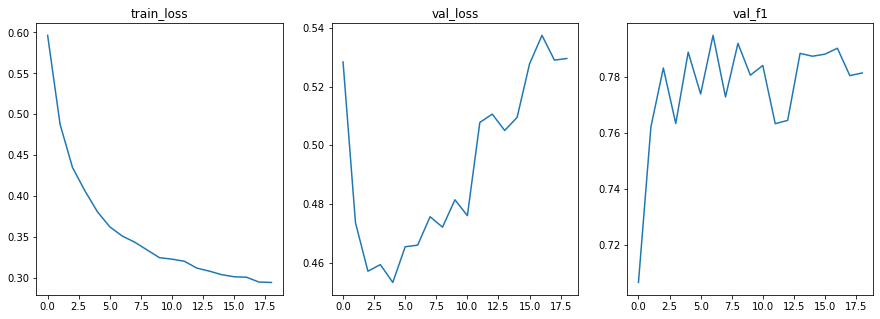

  Train loss:      0.294752
  Validation Loss: 0.529606
  Validation F1:   0.781409

Epoch 19


In [59]:
losses = []
losses_eval = []
f1s = []
f1s_eval = []
log = {'train_loss': [], 'val_loss': [], 'val_f1': []}

for i in range(20):
    print(f'\nEpoch {i}')
    epoch_loss = train(model, train_iterator, optimizer, criterion)
    losses.append(epoch_loss)
    f1_on_train,_ = evaluate(model, train_iterator, criterion)
    f1s.append(f1_on_train)
    f1_on_test, epoch_loss_on_test = evaluate(model, val_iterator, criterion)
    losses_eval.append(epoch_loss_on_test)
    f1s_eval.append(f1_on_test)
    log['train_loss'] = losses
    log['val_loss'] = losses_eval
    log['val_f1'] = f1s_eval

    if i % 3 == 0:
        clear_output(wait=True)
        fig, axs = plt.subplots(1, len(log), figsize=(15, 5))
        for i, (name, vals) in enumerate(log.items()):
            axs[i].plot(vals)
            axs[i].set_title(name)
        plt.show()
        print("  Train loss:      {0:.6f}".format(epoch_loss))
        print("  Validation Loss: {0:.6f}".format(epoch_loss_on_test))
        print("  Validation F1:   {0:.6f}".format(f1_on_test))

In [60]:
print(f'Best F1 on validation: {max(f1s_eval):.4f}')
print(f'Best epoch: {np.argmax(f1s_eval)}')

Best F1 on validation: 0.7948
Best epoch: 6


Бейзлайн: 0.7924  
Улучшенная: 0.7948

Я провела еще много разных экспериментов, но все оказывалось чуть хуже бейзлайна :(  
Например, я пробовала
* добавлять дропаут и активацию
* менять learning rate
* увеличивать размер окна в сверточных слоях
* добавлять сверточный слой и для эмбеддингов слов
* добавить еще два сверточных слоя для символьных эмбеддингов

## На каких текстах модель справляется хорошо, а на каких плохо

In [67]:
def predict(model, iterator):
    model.eval()
    fp = []
    fn = []
    tp = [] 
    tn = []
    with torch.no_grad():
        for i, (texts, symbols, ys) in enumerate(iterator):   
            preds = model(texts, symbols)  # делаем предсказания на тесте 
            for pred, gold, text in zip(preds, ys, texts):
              text = ' '.join([id2word[int(word)] for word in text if word !=0])
              if round(pred.item()) > gold:
                fp.append(text)
              elif round(pred.item()) < gold:
                fn.append(text)
              elif round(pred.item()) == gold == 1:
                tp.append(text)
              elif round(pred.item()) == gold == 0:
                tn.append(text)
    return fp, fn, tp, tn

In [68]:
fp, fn, tp, tn = predict(model, val_iterator)

**Угаданные Позитивные**
* Позитивные очень хорошо определяются, если в них есть D (очевидно, остатки смайлика :D)
* Модель посчитала, что ссылки (их кусочек - http) это признак позитивных предложений
* Довольно много слов капсом

**Угаданные Негативные**
* Модель хорошо справляется с негативными, в которых есть многоточие "...", которое не почитилось с остальной пунктуацией, потому что было одним токеном
* В негативных также больше мата, что русского, что английского
* Во многих предложениях есть отрицательная частица "не"

**НЕ-Угаданные Позитивные**
* Во многих есть многоточия, а их модель считает признаком негатива. (в этом модель в основном права, кстати. многие позитивные предложения из датасета с "..." не кажутся мне такими уж веселыми)
* Нейтральные предложения с "не"
* Нерусские предложения или короткие предложения на очень ломанном русском

**НЕ-Угаданные Негативные**
* Видимо, данные размечались как-то автоматически и принудительно должны были получить какой-то лейбл. Если смотреть глазами, то многие предложения словами не выражают негативные эмоции. Видимо, в них правда не хватает смайликов.
* Много коротких и неосмысленных предложений

In [82]:
print('Правильно предсказанные positive предложения\n')
print('\n'.join(tp[:10]))

Правильно предсказанные positive предложения

ВАНГУЮ ДЛЯ НИ ЗНАЮ 15 D
RT И как там выборы Мне из не видно
Да D и мы от нефиг делать стали фоткаться в зеркале D
RT Мой твит посвящается after_AD Дорогая пусть тебя за фолловят 1000 чуваков
спасибо удачно отучиться крошка моя
Самый лучший друг на свете http
скучно дома like good музыка маша медведь http
Iron_wings D Я приду домой и фор ю D
RT KnjazevAn сновидений © http
С Днём Рождения Желаю счастья успехов здоровья любви и всех благ


In [79]:
print('Правильно предсказанные negative предложения\n')
print('\n'.join(tn[:10]))

Правильно предсказанные negative предложения

Все никак не могу попасть на
Доброе утро Сегодня еле встала хочу спать ... Очень хочу спасать день обещает быть и долгим fuck
меня пиздец как то что я не могу его увидеть уже 3й день ебала какая злая Яна на что ж за хрень
хочу в Беларуси купить нереально его
RT очередная попытка поставить винду в этот раз уже действительно с
эм нет у нас почему-то такого не предлагают но он мне свой паспорт вместо проверки моего на скидку по др
это еще надо как-то выучить
Хочешь чтобы твит Лента ... .. просто что-то пишешь Лента ... окай
судя по адресу это рядом с
RT зачем я покрасилась в шоколадный поверх я больше не выйду из дома 99


In [85]:
print('Предсказано negative, а на самом деле positive\n')
print('\n'.join(fn[:10]))

Предсказано negative, а на самом деле positive

я всё ещё не могу оторваться от твоего оформления *~* Мне нельзя заходить на твой профиль х
покупок средств с других карт — бесплатный переводы друзьям на карты других банков — без комиссии
RT Krippin_73 BogdanTwittman ДА ЭТО
RT ananas__ananas бля как же повезло у них по биологии на её уроках мы так угарали а щас вапще скучно
гсн нь дараа чэн
Стоимость смс 500
подарок от Игоря хоть какая-то победа в этой жизни хд
wylsacom Валентин добро пожаловать к нам в Питер
Мои дома все поэтому дарят подарок и поздравляют не утра
почему он не объясняет как буквы я бы прочитала а оно блин


In [78]:
print('Предсказано positive, а на самом деле negative\n')
print('\n'.join(fp[:10]))

Предсказано positive, а на самом деле negative

`` Ты на я на каблуках '' не хотят публиковать меня
иногда полезно перед самым выходом в универ смотреть на расписание Оказывается туда надо идти только через пару
Совершенно не возможно играть Это сильнее чем иногда бывает Видимо дело в физике все таки
ага наверно 200
выступил офигенно только у меня шапочку забрали а ты как
RT утверждает что секс необходим для здоровой жизни меня унижает
RT Доброе утро вопрос как завтра вставать в шк
но если 13-го то я вечером работаю
msa_kla не помогает видимо что то на линии
О как мы любим Как в Мы то всего вернее Что сердцу нашему AutoFollowBack
